# setup

From a terminal session:

```
pip install upsetplot

# ensure gcloud installed: see https://cloud.google.com/sdk/docs/quickstart-linux
gcloud --version
```



In [157]:
from anvil import anvil
import sys

def projects_with_schemas(namespace='anvil-datastorage', project_pattern='AnVIL.*CCDG.*'):
    """Should return projects."""
    # get all matching projects in the namespace
    projects = anvil.get_projects([namespace], project_pattern=project_pattern)
    assert len(projects) > 0, "Should have at least 1 project in {} matching {}".format(namespace, project_pattern)
    # add the project schema    
    projects = [anvil.get_project_schema(p) for p in projects]
    for p in projects:
        if len(p.schema.keys()) == 0:
            print('{} missing schema'.format(p.project), file=sys.stderr)
    # trim projects without schemas        
    projects = [p for p in projects if len(p.schema.keys()) > 0]
    return projects
        
projects = projects_with_schemas()

# strip `AnVIL_CCDG_NYGC_NP_Autism_AGRE_WGS`  (participant data mis-imported on terra)
# projects = list(filter(lambda p: p.project != 'AnVIL_CCDG_NYGC_NP_Autism_AGRE_WGS', projects))

print([p.project for p in projects])

        

['AnVIL_CCDG_WashU_CVD_EOCAD_BioMe_WGS', 'AnVIL_CCDG_Broad_CVD_EOCAD_TaiChi_WGS', 'AnVIL_CCDG_Broad_AI_IBD_Brant_DS-IBD_WGS', 'AnVIL_CCDG_WashU_AI_T1D_T1DGC_WGS', 'AnVIL_CCDG_Broad_CVD_AFib_Penn_WGS', 'AnVIL_CCDG_WashU_CVD_EOCAD_Harvard-Costa-Rica_WGS', 'AnVIL_CCDG_WashU_CVD_EOCAD_WashU-CAD_GRU-IRB_WGS', 'AnVIL_CCDG_Broad_CVD_EOCAD_VIRGO_WGS', 'AnVIL_CCDG_Broad_CVD_AFib_AFLMU_WGS', 'AnVIL_CCDG_Broad_CVD_AFib_GENAF_WGS', 'AnVIL_CCDG_WashU_CVD_EOCAD_METSIM_WGS', 'AnVIL_CCDG_Broad_CVD_AFib_JHU_WGS', 'AnVIL_CCDG_Broad_CVD_AFib_MPP_WGS', 'AnVIL_CCDG_WashU_CVD_EOCAD_Finland-CHD_WGS', 'AnVIL_CCDG_NYGC_NP_Alz_LOAD_WGS', 'AnVIL_CCDG_NYGC_NP_Autism_SSC_WGS', 'AnVIL_CCDG_WashU_CVD_EOCAD_Penn_WGS', 'AnVIL_CCDG_NYGC_NP_Autism_ACE2_DS-MDS_WGS', 'AnVIL_CCDG_Broad_CVD_AFib_MGH_WGS', 'AnVIL_CCDG_NYGC_AI_Asthma_Gala2_WGS', 'AnVIL_CCDG_Broad_AI_IBD_McGovern_WGS', 'AnVIL_CCDG_Broad_AI_IBD_Cho_WGS', 'AnVIL_CCDG_NYGC_NP_Autism_SAGE_WGS', 'AnVIL_CCDG_Broad_AI_IBD_Newberry_WGS', 'AnVIL_CCDG_Baylor_CVD_HemStro

AnVIL_CCDG_WashU_CVD_EOCAD_BioImage_WGS missing schema


In [158]:
len(projects)

51

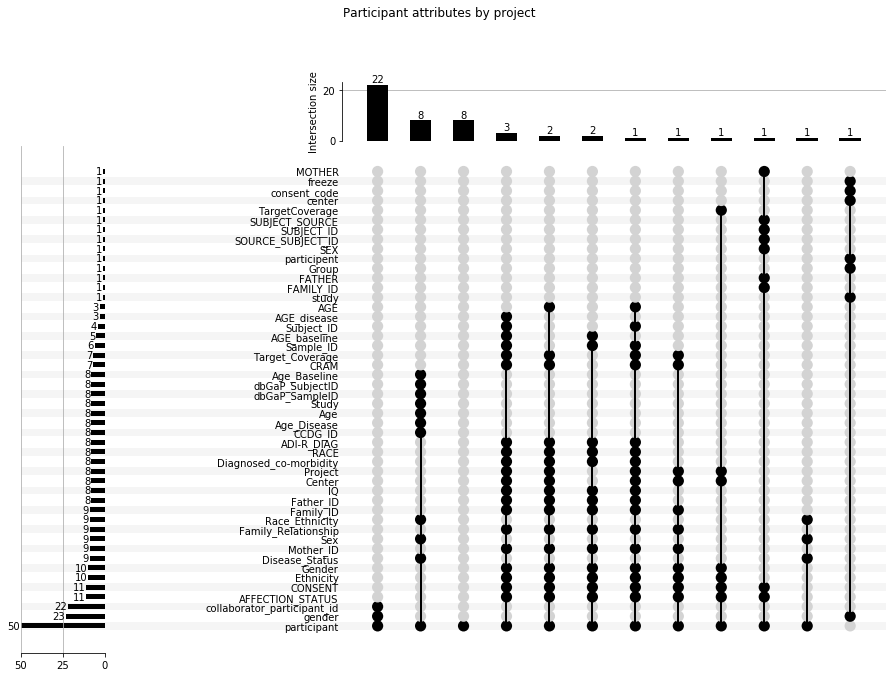

In [159]:
import matplotlib.pyplot
import pandas
import upsetplot

def upsetplot_attributes(project, entity):
    """Creates a dict useful for upsetplot"""
    d = {'project': project.project}
    d.update({n:True for n in sorted(project.schema[entity]['attributeNames'])})
    return d


attributes_df =  pandas.DataFrame([upsetplot_attributes(p, 'participant') for p in projects])

participants_attributes_df = attributes_df

attributes = [c for c in attributes_df.columns if c != "project"]
attributes_count_series = attributes_df.fillna(False).groupby(attributes).count()["project"]

upsetplot.plot(attributes_count_series, sort_by="cardinality", show_counts='%d' ) # 
current_figure = matplotlib.pyplot.gcf()
current_figure.suptitle('Participant attributes by project')
current_figure.set_size_inches(15.5, 10.5)
current_figure.savefig("ccdg_participant_attributes.png")


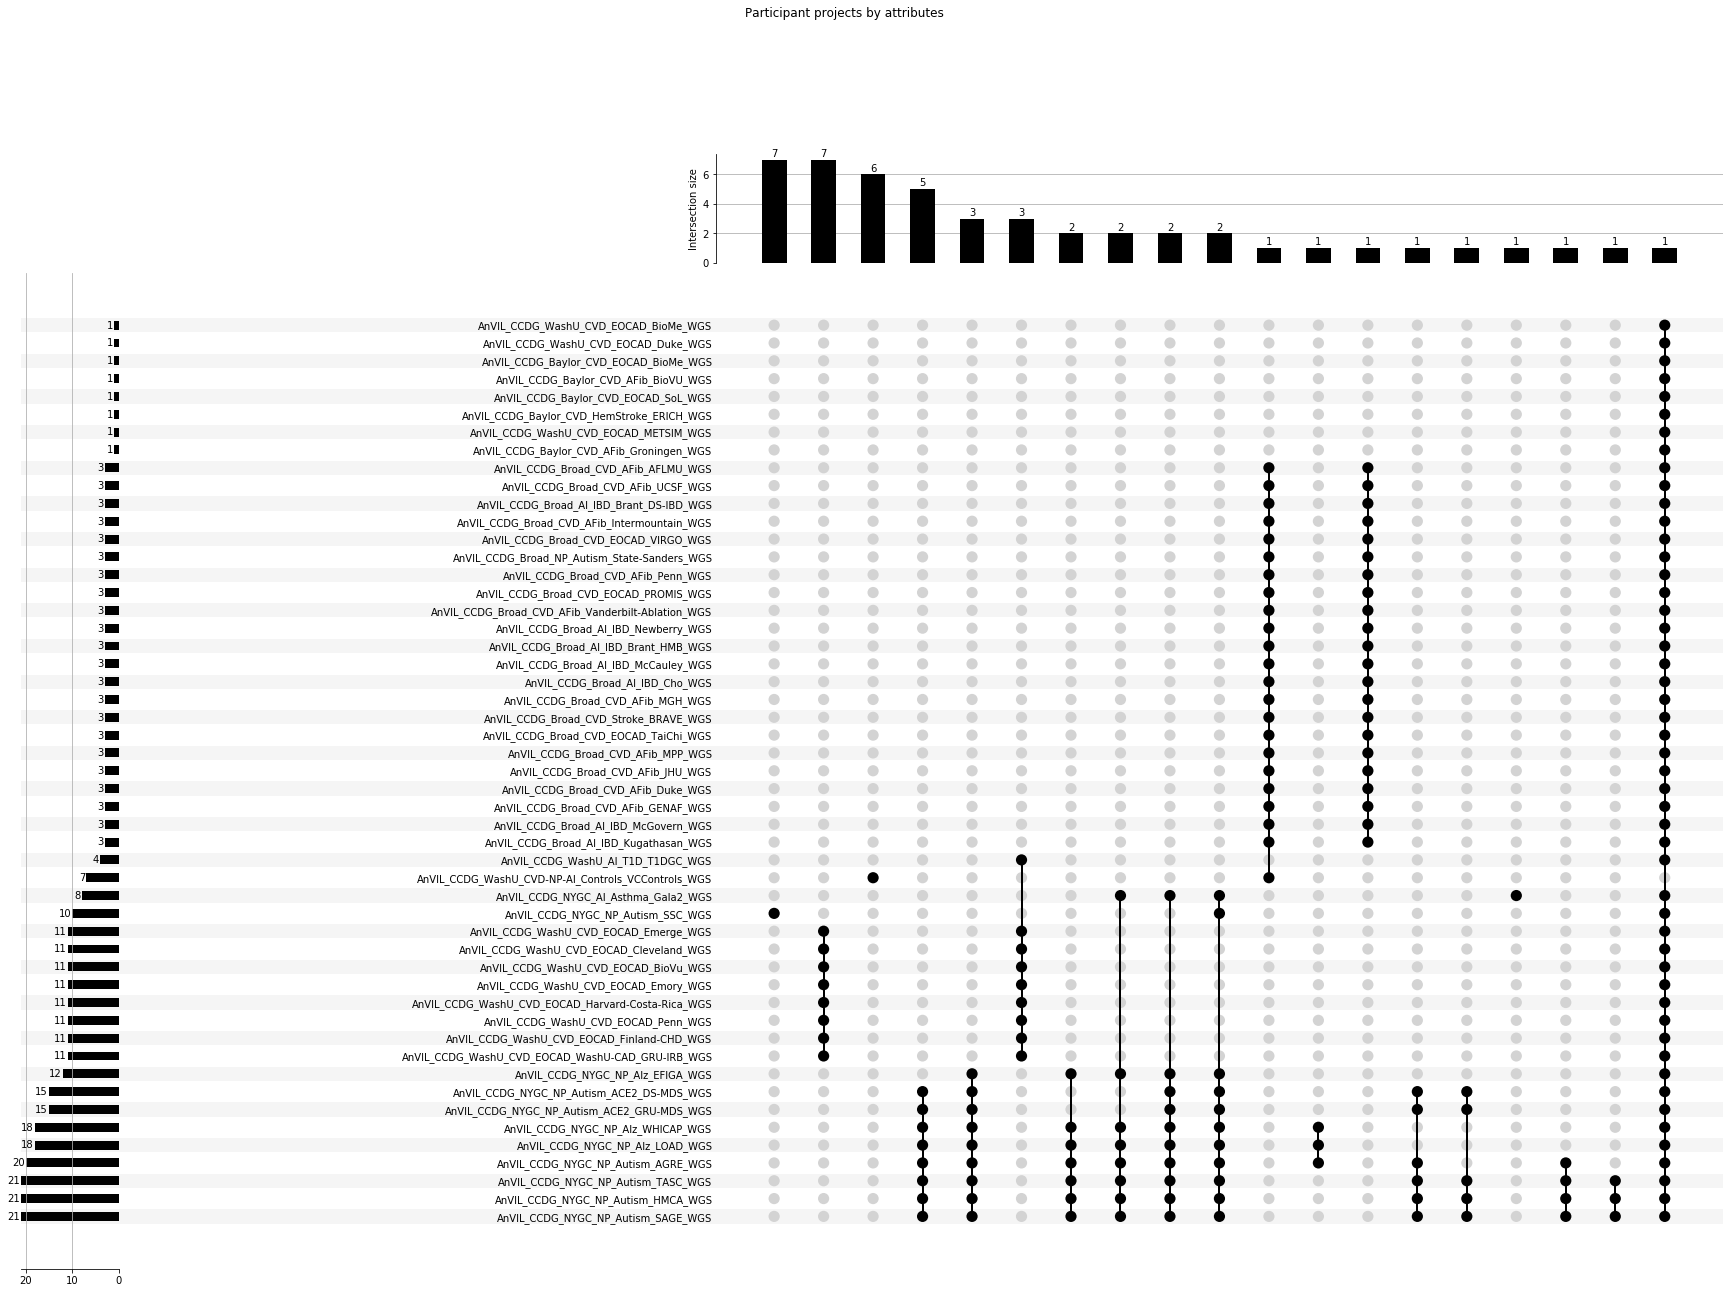

In [160]:
import matplotlib.pyplot
import pandas
import upsetplot

project_df =  pandas.DataFrame(upsetplot.from_contents({p.project: p.schema.participant.attributeNames for p in projects}))


upsetplot.plot(project_df, sort_by="cardinality", sum_over=False, show_counts='%d' ) # 
current_figure = matplotlib.pyplot.gcf()
current_figure.suptitle('Participant projects by attributes')
current_figure.set_size_inches(30.5, 20.5)
current_figure.savefig("ccdg_participant_project.png")

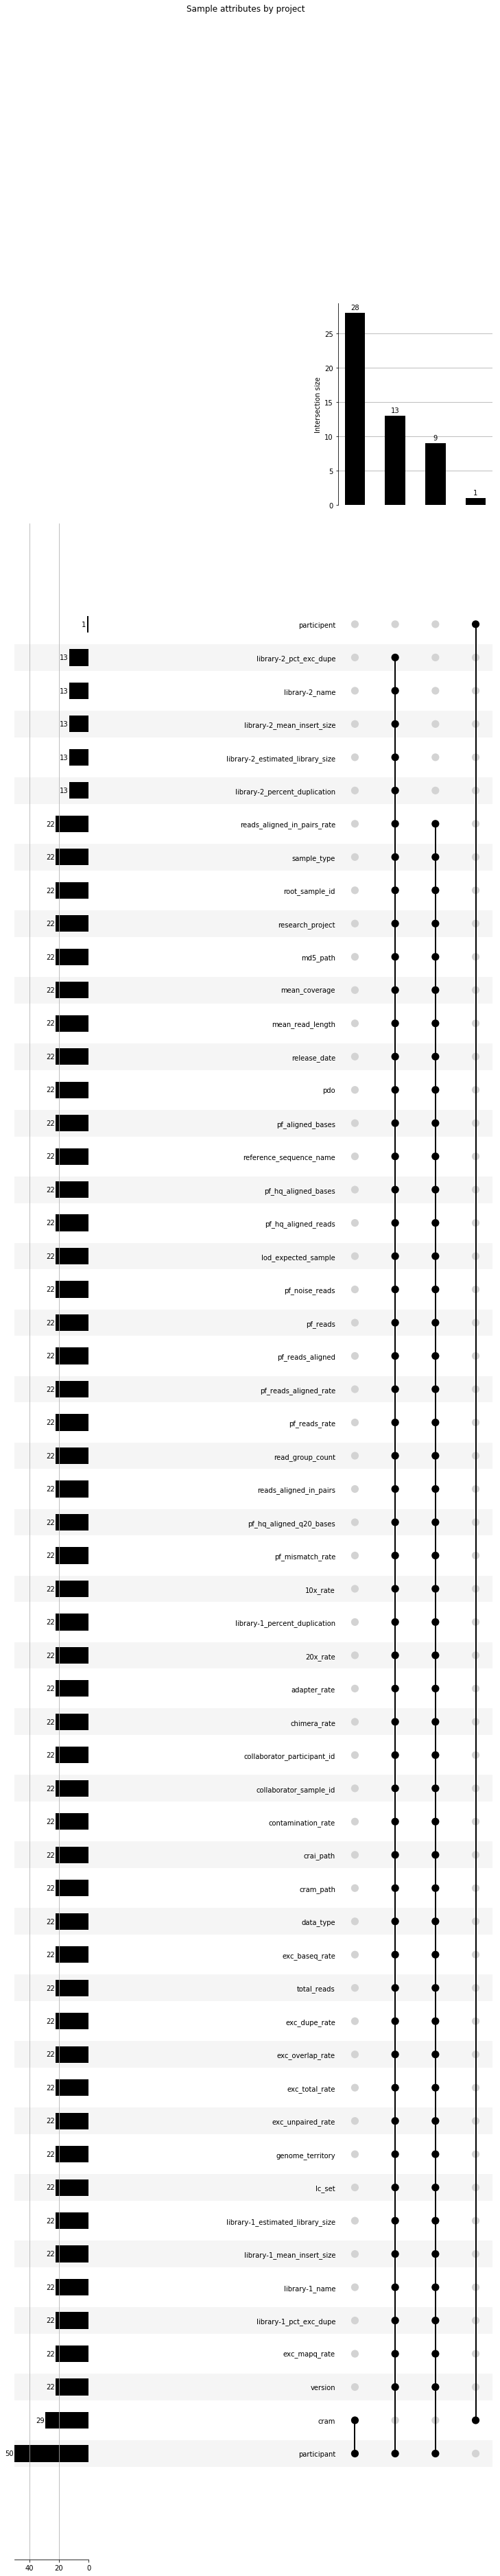

In [161]:
sample_attributes_df =  pandas.DataFrame([upsetplot_attributes(p, 'sample') for p in projects])

attributes = [c for c in sample_attributes_df.columns if c != "project"]
attributes_count_series = sample_attributes_df.fillna(False).groupby(attributes).count()["project"]

upsetplot.plot(attributes_count_series, sort_by="cardinality", show_counts='%d' ) # 
current_figure = matplotlib.pyplot.gcf()
current_figure.suptitle('Sample attributes by project')
current_figure.set_size_inches(12.5, 60.5)
current_figure.savefig("ccdg_sample_attributes.png")


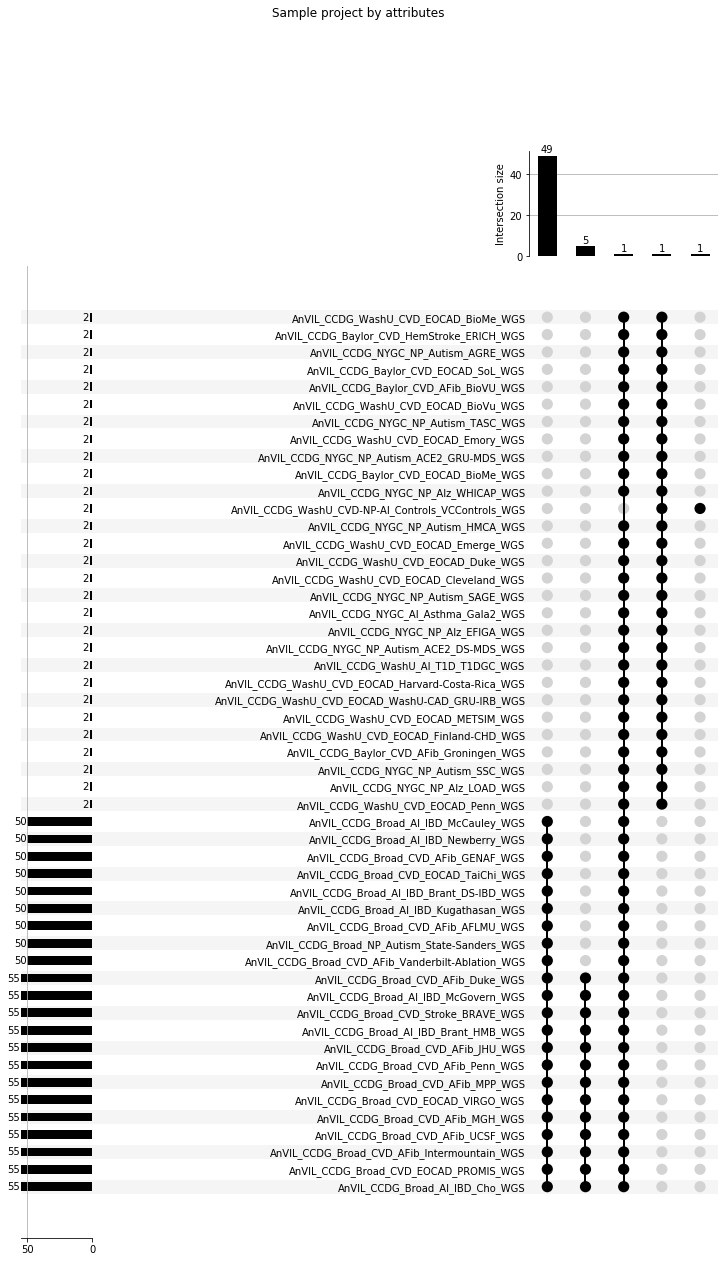

In [162]:
import matplotlib.pyplot
import pandas
import upsetplot

sample_project_df =  pandas.DataFrame(upsetplot.from_contents({p.project: p.schema.sample.attributeNames for p in projects}))

upsetplot.plot(sample_project_df, sort_by="cardinality", sum_over=False, show_counts='%d' ) # 
current_figure = matplotlib.pyplot.gcf()
current_figure.suptitle('Sample project by attributes')
current_figure.set_size_inches(12.5, 20)
current_figure.savefig("ccdg_sample_project.png")

In [163]:
import firecloud.api as FAPI
from attrdict import AttrDict

def get_entities(namespace='anvil-datastorage', workspace=None, entity_name=None, fapi=FAPI):
  """returns all entities in a workspace"""
  entities = [AttrDict(e) for e in fapi.get_entities(namespace,workspace, entity_name).json()]
  return entities


all_participants = []
for p in projects:    
    participants = get_entities(namespace=p.program, workspace=p.project, entity_name='participant')
    assert len(participants) == p.schema.participant.count
    for participant in participants:
        attributes = participant.attributes
        attributes.submitter_id = participant.name
        attributes.project_id = '{}-{}'.format(p.program, p.project)
        all_participants.append(attributes)
print('all_participants', len(all_participants))

all_samples = []
for p in projects:
    samples = get_entities(namespace=p.program, workspace=p.project, entity_name='sample')
    assert len(samples) == p.schema.sample.count
    for sample in [sample for sample in samples if 'attributes' in sample]:
        attributes = sample.attributes
        attributes.project_id = '{}-{}'.format(p.program, p.project)
        attributes.submitter_id = '{}/{}'.format(
            attributes.project_id,
            attributes.get('sample_alias', attributes.get('collaborator_sample_id'))
        )        
        all_samples.append(attributes)
print('all_samples', len(all_samples))


all_participants 54302
all_samples 54303


In [164]:
#!pip install networkx
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
G = nx.MultiDiGraph()

def plot_property_by_project(property_name, show_projects=False, show_nones=False, data_set=all_participants):

    property_count = defaultdict(int)
    for p in data_set:
        v = p.get(property_name, 'None')
        if v=='None' and not show_nones:
            continue
        property_count[v] += 1
    pandas.Series(property_count).sort_values(ascending=False).plot(kind='bar', title='{} counts'.format(property_name), figsize=(12,12))    
    current_figure = matplotlib.pyplot.gcf()
    current_figure.set_size_inches(30.5, 20.5)
    current_figure.savefig("ccdg_{}_bar.png".format(property_name))
    plt.xticks(rotation=25)
    plt.show()

    property_project = defaultdict(set)
    for p in data_set:
        v = p.get(property_name, 'None')
        if v=='None' and not show_nones:
            continue        
        property_project[v].add(p.project_id)
    property_project_df =  pandas.DataFrame(upsetplot.from_contents(property_project))
    upsetplot.plot(property_project_df, sort_by="cardinality", sum_over=False, show_counts='%d')
    current_figure = matplotlib.pyplot.gcf()
    current_figure.suptitle('{} values distribution(project counts)'.format(property_name))
    current_figure.savefig("ccdg_{}_values.png".format(property_name))

    current_figure.set_size_inches(30.5, 20.5)
    plt.show()

    if show_projects:
        project_property = defaultdict(set)
        for p in data_set:
            v = p.get(property_name, 'None')
            if v=='None' and not show_nones:
                continue                    
            project_property[p.project_id].add(v)
        project_property_df =  pandas.DataFrame(upsetplot.from_contents(project_property))
        upsetplot.plot(project_property_df, sort_by="cardinality", sum_over=False, show_counts='%d')
        current_figure = matplotlib.pyplot.gcf()
        current_figure.suptitle('{} project distribution (value counts)'.format(property_name))
        current_figure.savefig("ccdg_{}_projects.png".format(property_name))
        plt.show()


sibling    3965
mother     1752
father     1655
other      1104
proband     840
child       363
Name: family_relationship, dtype: int64


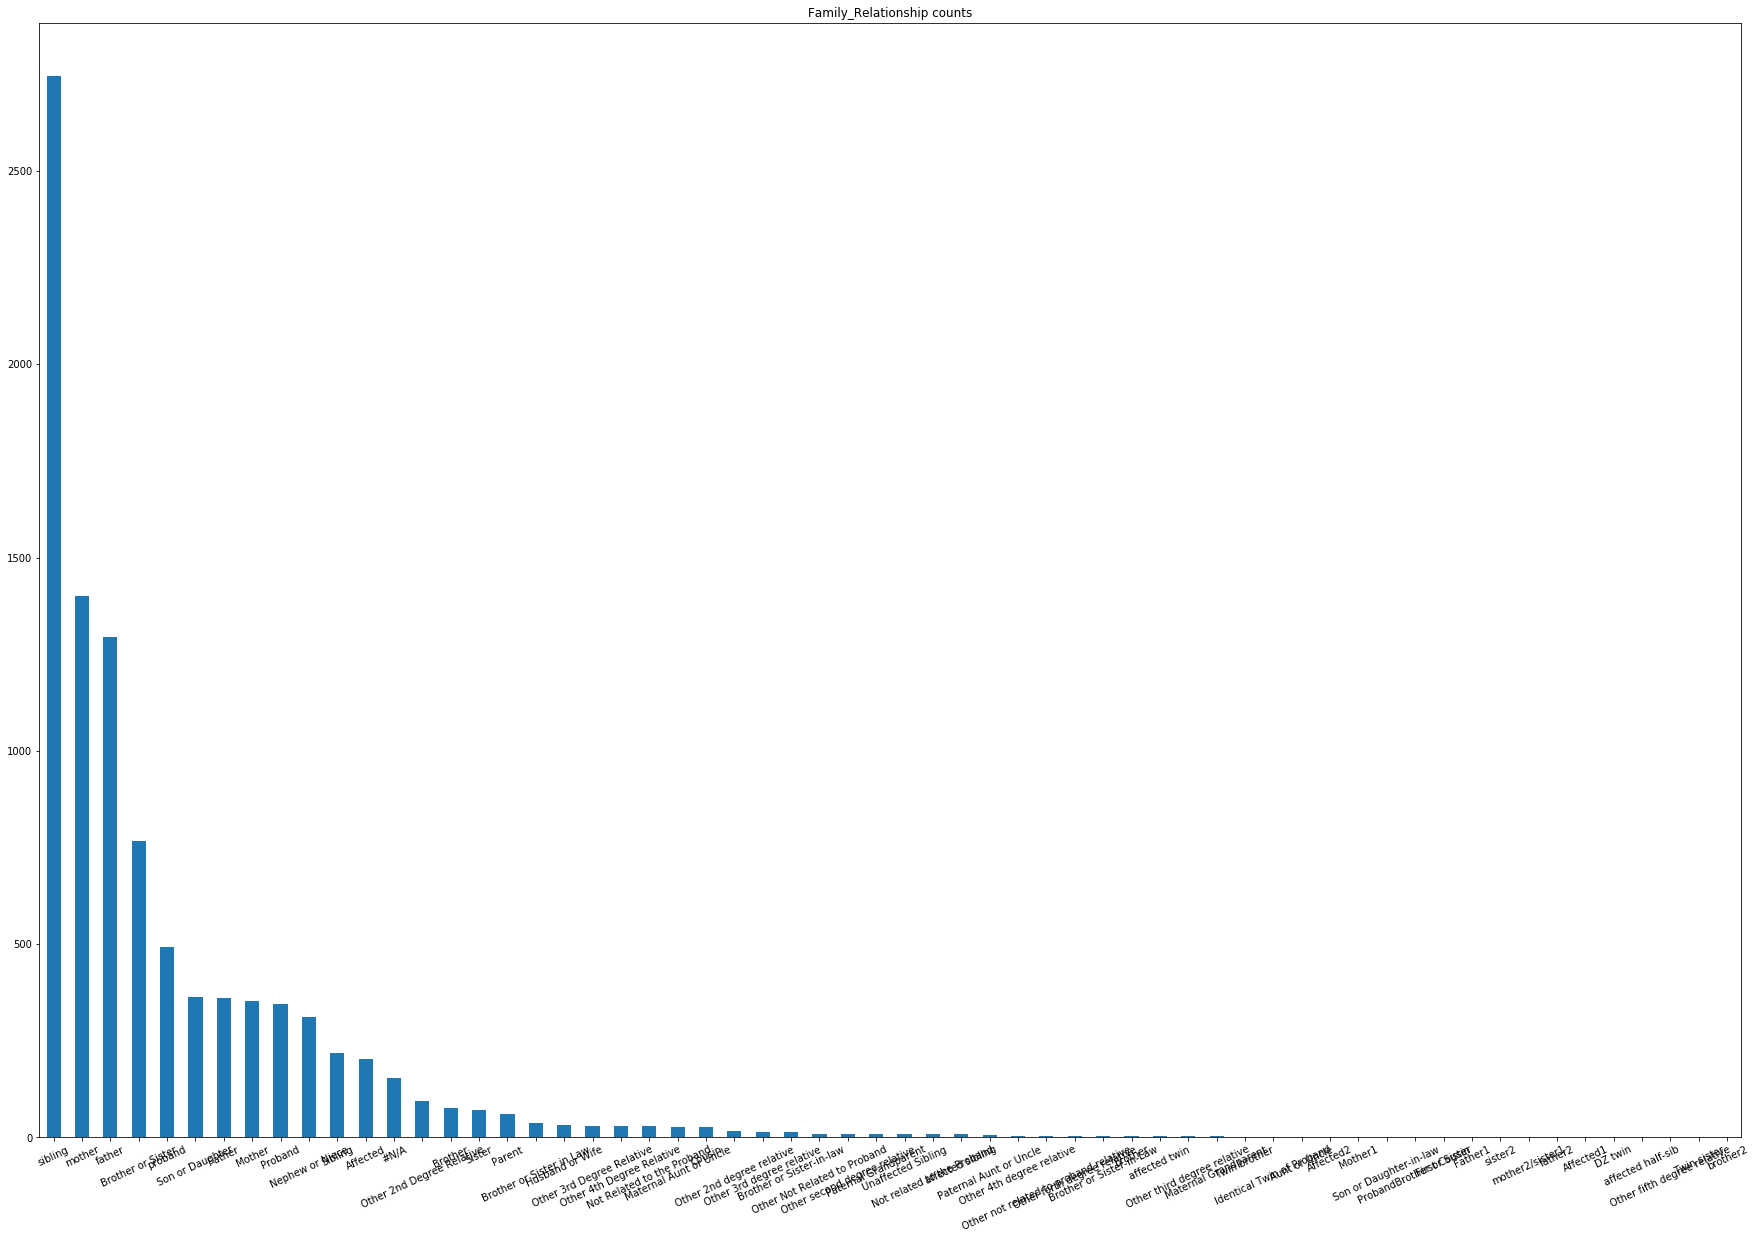

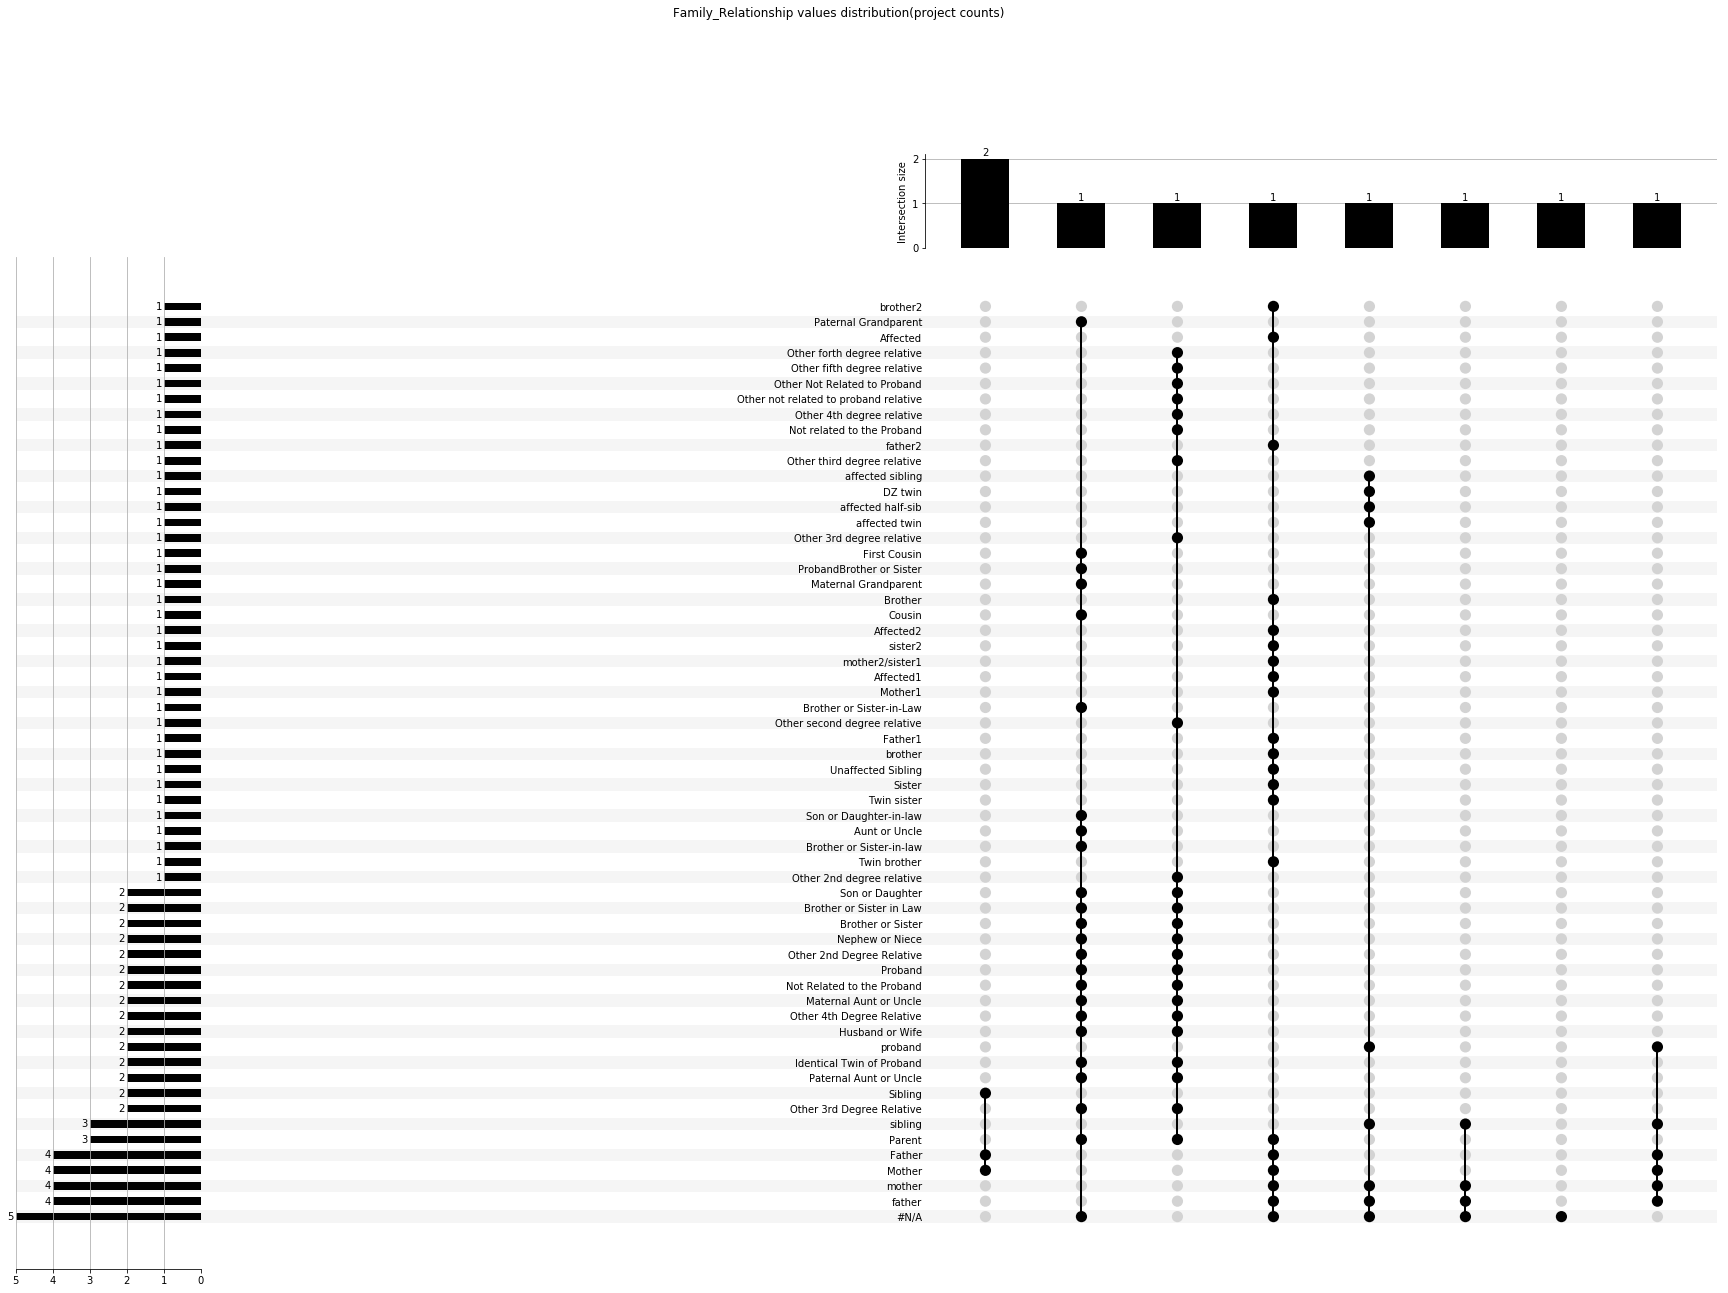

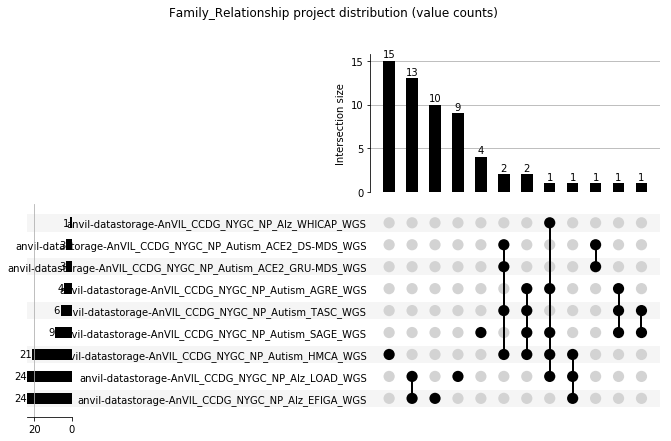

In [165]:
from collections import defaultdict
def strip_NA(v):
    if v in ['NA', '#N/A', 'N/A']:
        return None
    return v

def strip_0(v):
    if v in [0, '0']:
        return None
    return v


def harmonize_family_relationship(v):
    if not v:
        return v
    v = v.lower()
    if v in ['brother or sister', 'brother', 'sister']:
        v = 'sibling'
    for s in ['twin', 'sibling', 'brother', 'sister']:
        if s in v:
            v = 'sibling'
            break
    if v in ['son or daughter', 'son', 'daughter']:
        v = 'child'

    if v not in ['sibling', 'mother', 'father', 'proband', 'child']:
        v = 'other'
        
    return v


        
subjects = pandas.DataFrame([
    {
        'mother':strip_0(strip_NA(p.get('MOTHER', p.get('Mother_ID', None)))),
        'father':strip_0(strip_NA(p.get('FATHER', p.get('Father_ID', None)))),
        'subject_id':p.get('Subject_ID', p.get('SUBJECT_ID', None)),
        'submitter_id':p['submitter_id'], 
        'family_id': None if p.get('Family_ID', p.get('FAMILY_ID', None)) is None else p.get('Family_ID', p.get('FAMILY_ID', None)) + '_family', 
        'family_relationship':harmonize_family_relationship(p.get('Family_Relationship', None)), 
        'gender':strip_NA(p.get('Gender', p.get('Sex', None))), 
        'collaborator_participant_id':p.get('SOURCE_SUBJECT_ID', p.get('collaborator_participant_id', None)), 
        'age':strip_NA(p.get('AGE', p.get('Age', None))), 
        'age_baseline':strip_NA(p.get('AGE_baseline', p.get('AGE_baseline', None))), 
        'age_disease':strip_NA(p.get('Age_Disease', p.get('AGE_disease', None))), 
        'ethnicity':strip_NA(p.get('RACE', p.get('Race_Ethnicity', None))), 
        'center':strip_NA(p.get('SUBJECT_SOURCE', p.get('Center', None))), 
        'project_id':p.get('project_id'),
        'iq':strip_0(p.get('IQ', None)),  # all empty
        'diagnosis':strip_0(strip_NA(p.get('ADI-R_DIAG', None))),
        'Diagnosed_co-morbidity':strip_0(strip_NA(p.get('Diagnosed_co-morbidity', None))),  # all empty
        'AFFECTION_STATUS':strip_0(strip_NA(p.get('AFFECTION_STATUS', None))),   
        'target_coverage':strip_0(strip_NA(p.get('TargetCoverage', p.get('Target_Coverage', None)))),   
        'CRAM':strip_0(strip_NA(p.get('CRAM', None))),   
        'freeze':strip_0(strip_NA(p.get('freeze', p.get('freeze', None)))),   
        'disease_status':strip_0(strip_NA(p.get('Disease_Status', None))),   
    } for p in all_participants
]).sort_values(by='AFFECTION_STATUS')

#subjects.where(subjects['AFFECTION_STATUS'] == '2' , inplace = True) 

print(subjects['family_relationship'].value_counts())
plot_property_by_project('Family_Relationship', show_projects=True)

#subjects

In [166]:
subject_records = subjects.to_dict('records')
subject_records = [AttrDict(r) for r in subject_records]
# lookup participant.submitter_id
# family_lookup = {p['02_Individual_ID']:p['submitter_id'] for p in all_participants if '02_Individual_ID' in p}


In [167]:
families = {}
for p in subject_records:
    if p.family_id not in families:
        families[p.family_id] = AttrDict()
    if 'sibling' not in families[p.family_id]:
        families[p.family_id]['sibling'] = []
    if p.family_relationship == None and p.mother and p.father:
        families[p.family_id]['mother'] = [p.mother]
        families[p.family_id]['father'] = [p.father]
        families[p.family_id]['sibling'].append(p.submitter_id)
        continue
    if p.family_relationship == None:
        continue
    if p.family_relationship not in families[p.family_id]:
        families[p.family_id][p.family_relationship] = []
    families[p.family_id][p.family_relationship].append((p.submitter_id))

for k, f in families.items():
    if len(f.get('sibling', [])) == 0:
        del f['sibling']
    if len(f.get('sibling', [])) != 1:
        continue
    f['proband'] = f['sibling']
            

In [181]:
import os

def file_md5(v):
    if not is_file(v):
        return None
    filename, file_extension = os.path.splitext(v)
    if file_extension == '.md5':
        return v
    return None


def file_type(v):
    if not is_file(v):
        return None
    filename, file_extension = os.path.splitext(v)
    if file_extension == '.md5':
        return None
    return file_extension

def is_file(v):
    if isinstance(v, str) and v.startswith('gs://'):
        return True
    return False


def participant_id(s):
    if 'participant' in s:
        return s.participant.entityName
    if 'participent' in s:
        return s.participent

for s in all_samples:
    c = 0
    files = {}
    md5 = None
    paths = []
    for k,v in s.items():
        if is_file(v) and file_type(v):
            if v in paths:
                continue
            paths.append(v)    
            c += 1
            type = file_type(v).replace('.','').capitalize()
            files[type] = AttrDict({'path':v, 'type': file_type(v)})
        if file_md5(v):
            md5 = v
    if md5:
        md5_filename, md5_file_extension =  os.path.splitext(md5)
        for k,f in files.items():
            if f.path == md5_filename:
                f.md5 = md5
    s.files = files
    # only participant_id is consistent and uniq
    s.submitter_id = '{}-sample'.format(participant_id(s))
    s.participant_id = participant_id(s)

samples_df = pandas.DataFrame(all_samples)




In [185]:
#!pip install networkx
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
G = nx.MultiDiGraph()


subject_records = [AttrDict(s) for s in subjects.to_dict('records')]

projects = set([participant.project_id for participant in subject_records]) 

demographic_mapping = {
    'gender': 'gender',
    'iq': 'iq',
    'age': 'age',
    'age_baseline': 'age_baseline',
    'age_disease': 'age_disease',
    'eval:source["submitter_id"] + "_demographic"': 'submitter_id',
}

def map(source, target, mapping):
    """Maps source to target, controlled by mapping."""
    for source_key, target_key in mapping.items():
        # already set?
        if target_key in target and target[target_key]:
            continue
        if 'eval:' in source_key:
            val = target[target_key] = eval(source_key.replace('eval:',''), {'target': target, 'source': source})
        else:
            val = source.get(source_key, None)    
        if val == 'n/a':
            val = None
        if val:
            target[target_key] = val
    return target      

for project in projects:
    G.add_node(project, label='Project', submitter_id=project)
    
for subject in subject_records:
    assert subject.submitter_id, 'should have submitter_id'
    G.add_node(subject.submitter_id, label='Subject', **subject)
    G.add_edge(subject.submitter_id, subject.project_id, label='member_of')
    demographic = map(subject, AttrDict(), demographic_mapping)
    G.add_node(demographic.submitter_id, label='Demographic', **demographic)
    G.add_edge(subject.submitter_id, demographic.submitter_id, label='described_by')
    if 'diagnosis' in subject and subject.diagnosis:
        G.add_node(subject.diagnosis, label='Diagnosis')
        G.add_edge(subject.submitter_id, subject.diagnosis, label='has')
    
for sample in all_samples:
    G.add_node(sample.submitter_id, label='Sample')
    G.add_edge(sample.participant_id, sample.submitter_id, label='drawn_from')
    for k,file in sample.files.items():
        type = file.type.replace('.','').capitalize()
        G.add_node(file.path, label='{}File'.format(type))
        G.add_edge(sample.submitter_id, file.path, label=k)


for family_id, family in families.items():
    G.add_node(family_id, label='Family')
    for family_relationship in family:
        for member in family[family_relationship]:
            G.add_edge(member, family_id, label='member_of')           
        proband = family.get('proband', [None])[0]
        if proband:
            for member in family.get('father', []):
                G.add_edge(member, proband, label='father')           
                G.add_edge(proband, member, label='child')           
            for member in family.get('mother', []):
                G.add_edge(member, proband, label='mother')           
                G.add_edge(proband, member, label='child')           
        siblings = family.get('sibling', [])
        for member in siblings:
            other_siblings = [s for s in siblings if s != member]
            for s in other_siblings:
                G.add_edge(member, s, label='sibling')
        
        
# for participant in all_participants:
#     subject = map(participant, AttrDict(), participant_mapping)
#     if 'family_id' in subject:
#         G.add_edge(subject.submitter_id, subject.family_id, label='member_of')
#     if 'paternal_id' in subject and subject.paternal_id in family_lookup:
#         G.add_edge(subject.submitter_id, family_lookup[subject.paternal_id], label='father')
#         G.add_edge(family_lookup[subject.paternal_id], subject.submitter_id, label='child')
#     if 'maternal_id' in subject and subject.maternal_id in family_lookup:
#         G.add_edge(subject.submitter_id, family_lookup[subject.maternal_id], label='mother')
#         G.add_edge(family_lookup[subject.maternal_id], subject.submitter_id, label='child')
#     if 'phenotype_id' in subject:
#         diagnosis_id = '{}/{}'.format(subject.submitter_id, subject.phenotype_id)
#         G.add_node(diagnosis_id, label='Diagnosis')
#         G.add_edge(subject.submitter_id, diagnosis_id, label=subject.affected_status)
#         G.add_edge(diagnosis_id, subject.phenotype_id, label='instance_of')
#     if 'present' in subject:
#         observation_id = '{}/{}'.format(subject.submitter_id, subject.present)
#         G.add_node(observation_id, label='Observation')
#         G.add_edge(subject.submitter_id, observation_id, label='present')
#         G.add_edge(observation_id, subject.present, label='instance_of')
#     if 'absent' in subject:
#         observation_id = '{}/{}'.format(subject.submitter_id, subject.absent)
#         G.add_node(observation_id, label='Observation')
#         G.add_edge(subject.submitter_id, observation_id, label='absent')
#         G.add_edge(observation_id, subject.absent, label='instance_of')
#     if 'gene' in subject:
#         G.add_edge(subject.submitter_id, subject.gene, label='expressed')
#     G.add_edge(subject.submitter_id, subject.project_id, label='member_of')
                    

            
# for sample in all_samples:
#     G.add_node(sample.submitter_id, label='Sample')
#     G.add_edge(sample.participant_id, sample.submitter_id, label='drawn_from')
#     for k,file in sample.files.items():
#         type = file.type.replace('.','').capitalize()
#         G.add_node(file.path, label='{}File'.format(type))
#         G.add_edge(sample.submitter_id, file.path, label=k)
        
    
        

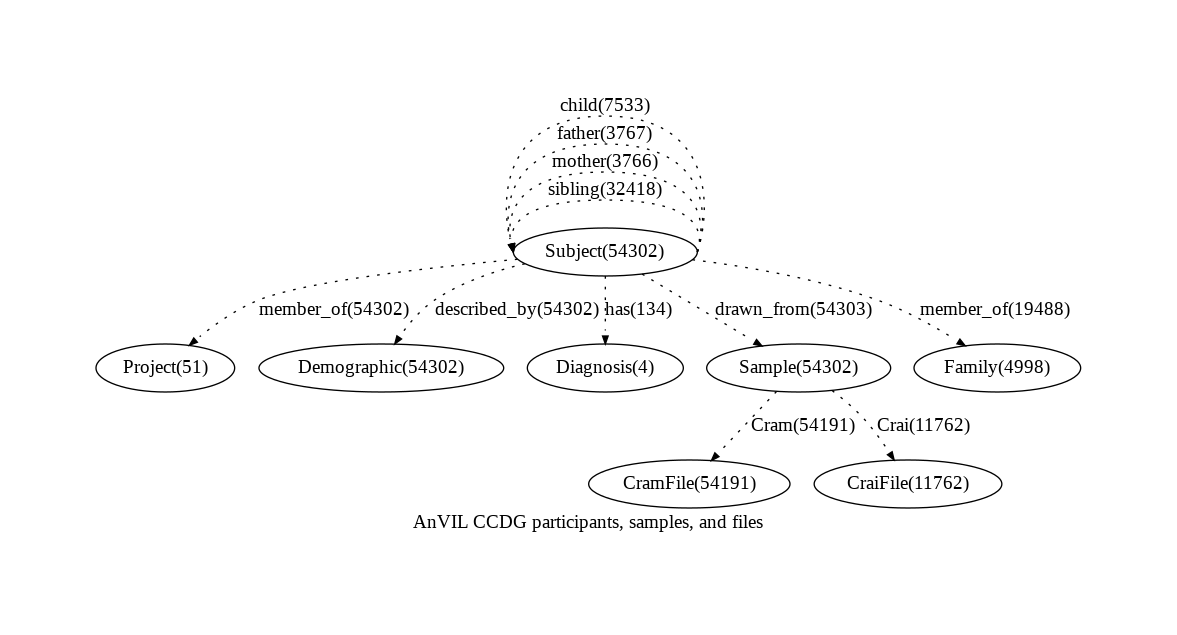

In [186]:
from IPython.display import Image
import pygraphviz

def summarize_graph(graph):
    """Introspects the data in the graph, creates a summary graph.  Relies on label attribute on each node"""
    # calc labels and edge lables
    labels = defaultdict(int)
    for k, v in graph.nodes.data():
        labels[v['label']] += 1
    for k, v in labels.items():
        labels[k] = '{}({})'.format(k, v)

    edge_labels = defaultdict(int)
    for n in graph.nodes():
        lable = graph.node[n]['label']
        for neighbor in graph.neighbors(n):
            n_lable = graph.node[neighbor]['label']
            edges = graph.get_edge_data(n, neighbor)
            for e in edges.values():
                edge_labels[(lable, n_lable, e['label'] )] += 1
    for k, v in edge_labels.items():
        edge_labels[k] = '{}'.format(v)

    # create new summary graph
    g = pygraphviz.AGraph(strict=False, directed=True)
    
    
    for k in labels:
        g.add_node(k, label=labels[k])

    compass_points = [('e','w')]        
            
    for k in edge_labels:
        start = k[0]
        end = k[1]
        key = k[2]
        # use compass points for self loops
        opts = {}
        if start == end:
            compass_point_offset = len([e for e in g.out_edges([start]) if e[1]==start]) % len(compass_points)
            compass_point = compass_points[compass_point_offset]
            opts = {'headport': compass_point[1], 'tailport': compass_point[0]}
        g.add_edge(start, end, label='{}({})'.format(k[2], edge_labels[k]), labeldistance=0,  **opts)

    return g


def draw_summary(g, label='<untitled>', prog='dot'):
    # ['dot', 'neato', 'twopi', 'circo', 'fdp', 'sfdp']
    g.layout(prog)                                                                 
    g.graph_attr.update(label=label, size = '40,40', pad=1) 
    g.edge_attr.update(arrowsize='0.6', style='dotted')
    g.graph_attr.update(scale=3) # , nodesep=1, ratio='auto')

    g.draw('{}.png'.format(label))  
    return Image('{}.png'.format(label))     


sumary_graph = summarize_graph(G)
draw_summary(sumary_graph,
             prog='dot',
             label='AnVIL CCDG participants, samples, and files')


In [187]:
import json
from networkx.readwrite import json_graph
ccdg_json = json_graph.node_link_data(G)
with open('bmeg_etl/notebooks/ccdg_json.json', 'w') as outputs:
    json.dump(ccdg_json, outputs)
    